# Classifying Game Newsletter Subscribers Based on Player Behavior

In [40]:
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 10)

---

## Background

In the gaming industry, understanding **user engagement** and predicting **subscription behavior** is critical for improving marketing strategies and enhancing player retention. This project explores how player behavior and demographic characteristics are associated with their likelihood of subscribing to a game-related newsletter. Understanding this pattern will help optimize marketing timing and content targeting.


## Question
I aim to answer the following question:
**How strong is the association between the top two predictors and subscription status?**


## Data Description
| Variable       | Type     | Description                                                                 |
|----------------|----------|-----------------------------------------------------------------------------|
| `experience`   | Categorical (`chr`) | Player's experience level (e.g., Pro, Veteran, etc.)                      |
| `subscribe`    | Logical (`lgl`)      | Whether the player subscribed to the newsletter (`TRUE` or `FALSE`)       |
| `hashedEmail`  | String (`chr`)       | Anonymized email ID (not used for analysis)                              |
| `played_hours` | Numeric (`dbl`)      | Total number of hours the player has played                              |
| `name`         | String (`chr`)       | Player name (not used for analysis)                                      |
| `gender`       | Categorical (`chr`)  | Player gender                                                             |
| `Age`          | Numeric (`dbl`)      | Player age  |


This dataset consists of 7 variables and an unspecified number of observations. For the purpose of this project, our focus will be on a few key explanatory variables—such as `played_hours`, `Age`, `experience`, and `gender`—to predict the response variable `subscribe`, which indicates whether a player signed up for the game's newsletter. Although the dataset includes additional fields like `hashedEmail` and `name`, these are not relevant for our predictive modeling and will be excluded from the analysis. 

---

## Let's start by loading the data:

In [41]:
data <- read_csv("data/players.csv")
data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


First, we handle variable types appropriately: `played_hours` and `Age` are kept as numerical features, while `gender` and `experience` are converted into dummy variables to facilitate their use in machine learning models. Unnecessary fields such as `name` and `hashedEmail`, which do not contribute to prediction, are excluded from the final dataset. 

In [42]:
data_clean <- data|> 
select(subscribe,experience, Age,gender,played_hours) |> 
filter(!is.na(subscribe))|>
filter(!is.na(experience))|>
filter(!is.na(Age))|>
filter(!is.na(gender))|>
filter(!is.na(played_hours))|>
  mutate(gender = as.factor(gender),
    experience = as.factor(experience),
    subscribe = as.factor(subscribe))
data_clean

subscribe,experience,Age,gender,played_hours
<fct>,<fct>,<dbl>,<fct>,<dbl>
TRUE,Pro,9,Male,30.3
TRUE,Veteran,17,Male,3.8
FALSE,Veteran,17,Male,0.0
TRUE,Amateur,21,Female,0.7
TRUE,Regular,21,Male,0.1
⋮,⋮,⋮,⋮,⋮
TRUE,Amateur,20,Male,0.0
TRUE,Amateur,17,Female,0.0
FALSE,Veteran,22,Male,0.3


---
## **Exploratory Data Analysis**

To explore how different variables are associated with newsletter subscription, we created four visualizations focusing on age, playtime, experience level, and gender. Each chart is labeled and follows best practices in visualization, including clear axis labels, units, and legends.

## 1. continuous variables (e.g.,Age, played_hours) are plotted with histogram:

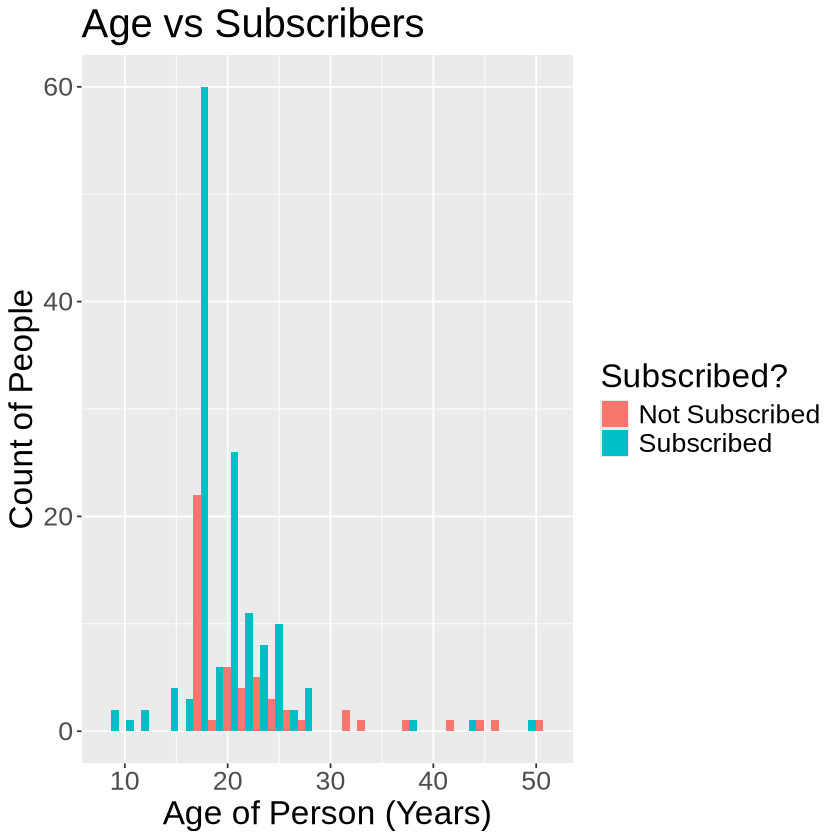

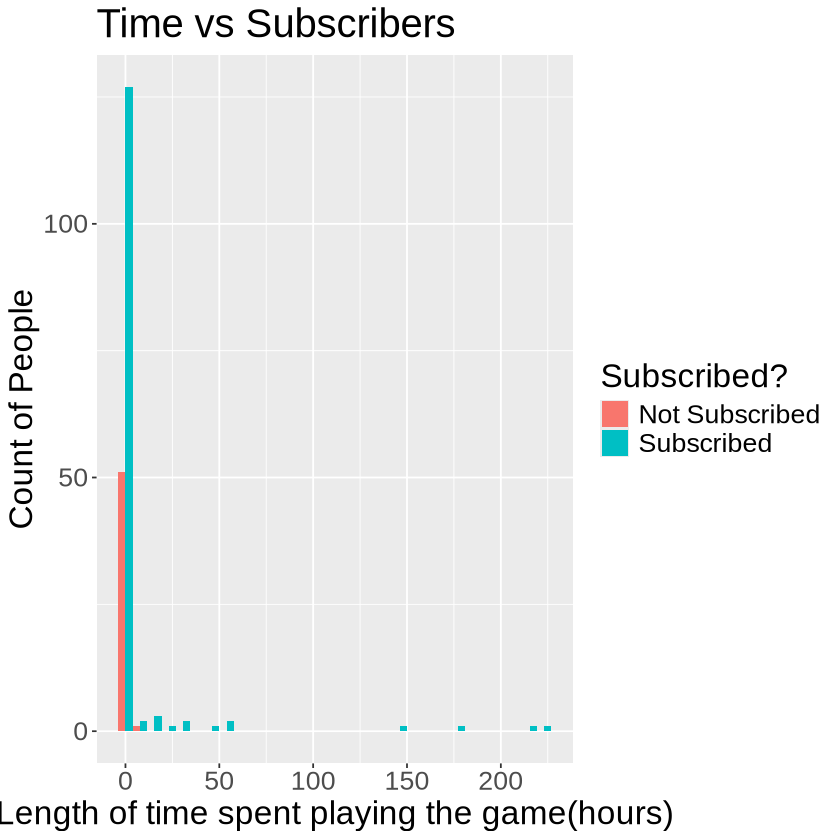

In [43]:
figure1 <-ggplot(data_clean,aes(x = Age, fill = subscribe)) +
    geom_histogram(position = "dodge",bins=30) + 
    labs(x = "Age of Person (Years)", 
         y = "Count of People", 
         fill = "Subscribed?",
         title = "Age vs Subscribers") +
    scale_fill_discrete(labels = c("Not Subscribed", "Subscribed")) +
    theme(text = element_text(size = 20))

figure2 <-ggplot(data_clean,aes(x = played_hours, fill = subscribe)) +
    geom_histogram(position = "dodge",bins=30) + 
    labs(x = "Length of time spent playing the game(hours)", 
         y = "Count of People", 
         fill = "Subscribed?",
         title = "Time vs Subscribers") +
    scale_fill_discrete(labels = c("Not Subscribed", "Subscribed")) +
    theme(text = element_text(size = 20))
figure1
figure2

### Figure 1: Age vs. Subscription Status

This histogram shows the distribution of player age grouped by subscription status. Most players are between 15 and 25 years old, with a noticeable concentration around age 18–21. Within this group, the number of subscribers is consistently higher than non-subscribers. This suggests that **age may be positively associated** with the likelihood of subscription, especially within a certain age window. Very young and very old players are relatively rare and have low subscription rates.

### Figure 2: Played Time vs. Subscription Status

In this histogram, we see that the majority of players spent fewer than 10 hours playing the game. However, among those who played longer (e.g., over 20 hours), the proportion of subscribers increases significantly. This pattern implies that time spent playing the game (played_hours)** is also **a strong predictor** of whether a user subscribes. The longer someone plays, the more likely they are to subscribe.


## 2. Bar charts are used for categorical variables (eg.,experience, gender):

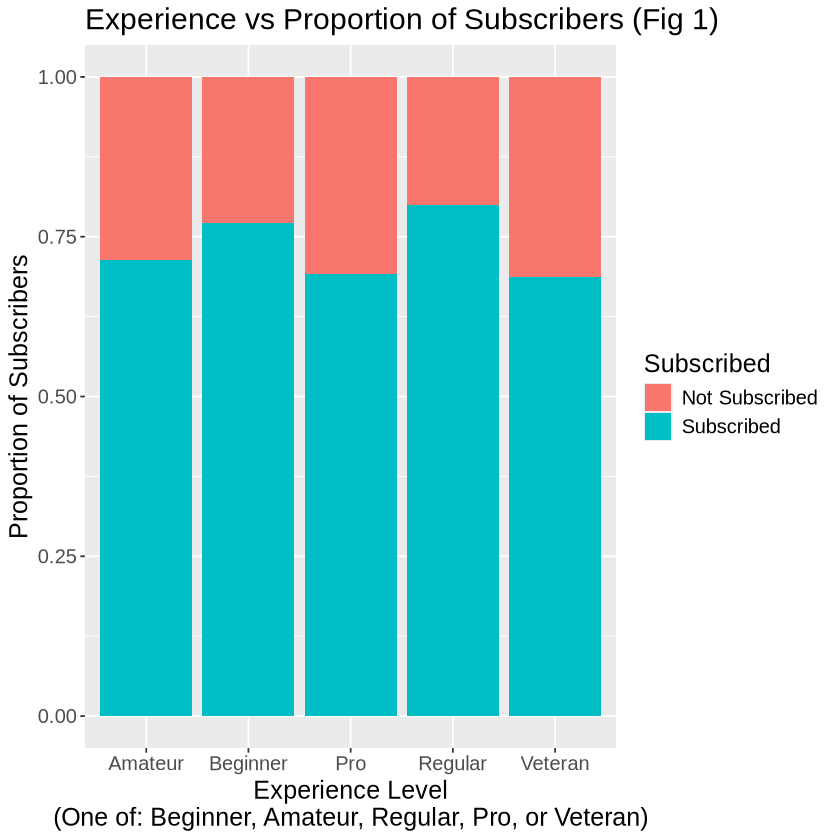

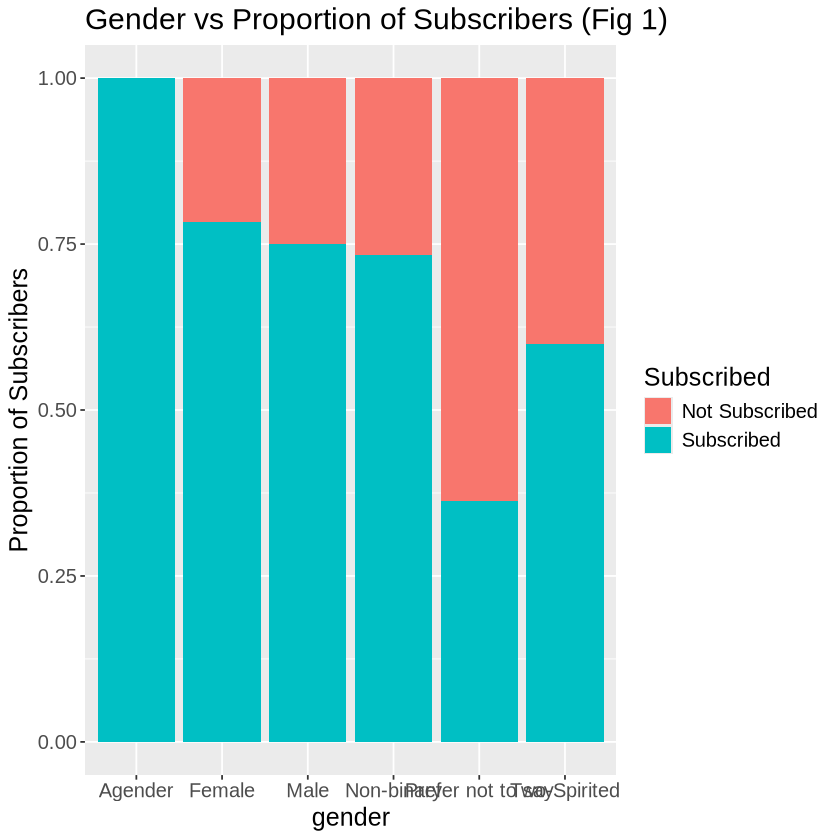

In [44]:
figure3 <- ggplot(data_clean, aes(x = experience, fill = subscribe)) +
    geom_bar(position = "fill") +
    labs(x = "Experience Level\n(One of: Beginner, Amateur, Regular, Pro, or Veteran)", 
         y = "Proportion of Subscribers", 
         fill = "Subscribed",
         title = "Experience vs Proportion of Subscribers (Fig 1)") +
    scale_fill_discrete(labels = c("Not Subscribed", "Subscribed")) + 
    theme(text = element_text(size = 15))

figure4 <- ggplot(data_clean, aes(x = gender, fill = subscribe)) +
    geom_bar(position = "fill") +
    labs(x = "gender", 
         y = "Proportion of Subscribers", 
         fill = "Subscribed",
         title = "Gender vs Proportion of Subscribers (Fig 1)") +
    scale_fill_discrete(labels = c("Not Subscribed", "Subscribed")) + 
    theme(text = element_text(size = 15))

figure3 
figure4

### Figure 3: Experience Level vs. Proportion of Subscribers

This stacked bar plot displays the proportion of subscribers in each experience level. All categories show a majority of subscribers, with the highest proportions seen in "Regular" and "Pro" players. While not as sharply differentiated as age or playtime, **experience level still correlates positively** with subscription likelihood.

### Figure 4: Gender vs. Proportion of Subscribers

This chart shows subscription proportions across gender identities. While most gender groups display a majority of subscribers, the **differences are less pronounced** than for other variables. For example, "Two-Spirited" and "Prefer not to say" groups have noticeably lower subscription rates, but their sample sizes may be small. Overall, **gender seems less predictive** compared to age or playtime.


### **Insights Summary**

From the visualizations, we observe that **Age** and **played_hours** appear to be the most important predictors of subscription.

---
## **Modeling and Evaluation**

To predict whether a player will subscribe based on their age and time spent playing (`played_hours`), we used a **K-Nearest Neighbors classifier**. The target variable `subscribe` is a **categorical boolean** (TRUE/FALSE), making this a **classification task** rather than regression. Also, KNN is a simple yet effective algorithm that doesn't require strong assumptions about the data distribution.

### **Model Selection Strategy**
We compare different values of k (from `1` to `10`) based on cross-validated accuracy, and select the value of k that yields the highest average accuracy across the `5` folds. KNN assumes that similar observations are located near each other in feature space. Thus, **scaling the data** is crucial so that one feature doesn't dominate the distance calculation.

In [45]:
set.seed(123)


players_split <- initial_split(data_clean, prop = 0.75, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)

In [46]:
# Set training_vfold
training_vfold = vfold_cv(players_train, v = 5, strata = subscribe)
#set the recipe
all_pred_recipe = recipe(subscribe ~ played_hours + Age, data = data_clean) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

#set specification
test_ks_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

# Set the k-values
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# Train the model and collect its metrics into knn_results
knn_results <- workflow() |>
      add_recipe(all_pred_recipe) |>
      add_model(test_ks_spec) |>
      tune_grid(resamples = training_vfold, grid = k_vals) |>
      collect_metrics()

# Find the accuracy from the knn_results
accuracies <- knn_results |> 
      filter(.metric == "accuracy")

### **Found the best k**

[1] 9

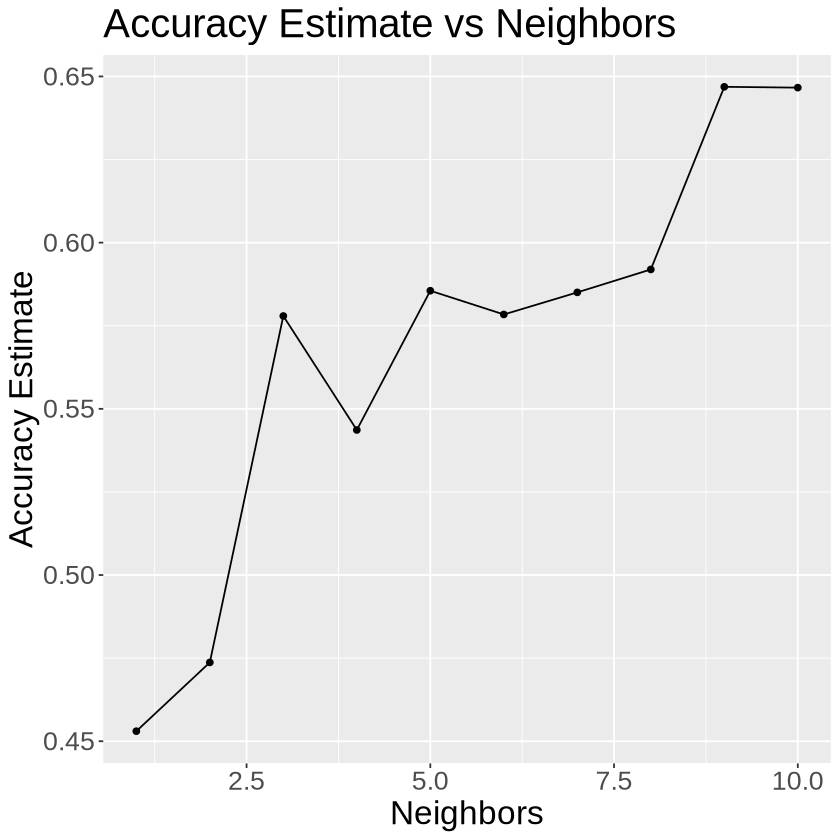

In [47]:
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy Estimate vs Neighbors") +
      theme(text = element_text(size = 20))

cross_val_plot
# pick the best
 best <- accuracies|> 
        arrange(desc(mean))|>
        head(1)|>
        pull(neighbors)
best

After tuning the model using 5-fold cross-validation, we found that the optimal number of neighbors (`k`) was 9. Using this `k`, we retrained the model on the full training set and evaluated its performance on the test set.

In [48]:
players_spec =  nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
      set_engine("kknn") |>
      set_mode("classification")

players_fit = workflow() |>
      add_recipe(all_pred_recipe) |>
      add_model(players_spec) |>
      fit(data = players_train)


players_predictions = predict(players_fit, players_test) |> 
                      bind_cols(players_test)
players_predictions
     

.pred_class,subscribe,experience,Age,gender,played_hours
<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>
TRUE,TRUE,Veteran,17,Male,3.8
FALSE,FALSE,Veteran,17,Male,0.0
TRUE,TRUE,Amateur,21,Female,0.7
TRUE,FALSE,Amateur,21,Male,0.0
FALSE,TRUE,Pro,17,Male,0.0
⋮,⋮,⋮,⋮,⋮,⋮
TRUE,TRUE,Amateur,17,Two-Spirited,0.4
TRUE,FALSE,Pro,17,Male,0.2
FALSE,TRUE,Beginner,17,Female,0.0


In [49]:
players_metrics = metrics(players_predictions, truth = subscribe, estimate = .pred_class)   
accuracy = players_metrics |> 
           filter(.metric == "accuracy") |> 
           select(.estimate) |> 
           pull()
accuracy

[1] 0.6938776

---
## **Results and Discussion**

The final model achieved an **accuracy of approximately 0.694** on the held-out testing data. This means that the model correctly predicted whether a player subscribed or not about **69.4%** of the time.


## Limitations of the Data

One major challenge with this dataset is the **limited variability in key features**. Most players are between the ages of 15 and 25, and many have very low values for `played_hours`. This clustering reduces the model's ability to distinguish between subscribers and non-subscribers, especially since **many players with similar age and playtime have different subscription outcomes**.

Moreover, with only two numerical predictors, the model might miss important context or interactions that influence a player's likelihood to subscribe. For example, categorical variables like `experience` or `gender` might provide additional predictive power if incorporated properly.

To improve the model, future work could focus on incorporating additional predictors such as `experience`, `gender` that may influence subscription decisions. Exploring alternative modeling approaches could also provide more interpretable or better-performing results. Furthermore, collecting more diverse data would help address the current limitations related to data homogeneity and enhance the model’s ability to generalize.